# Notebook for a Neural Network Model

In [116]:
from matplotlib import pyplot as plt

# Import necessary functions and modules
from src.utils.check_mps_device import check_mps_device
from src.utils.data_loading import load_data
from src.utils.filtering import filter_data
from src.utils.label_encoding import label_encode_column
import numpy as np

# Check if PyTorch Multi-Process Service (MPS) is available (GPU)
check_mps_device()

tensor([1.], device='mps:0')


# 1) Preprocessing

## a) Selected Features

In [117]:
# Define a list of selected features for analysis from the feature_selection notebook
selected_features = [
    "geocentric_latitude",  # Latitude of conjunction point [deg]
    "c_sigma_rdot",  # Covariance: radial velocity standard deviation (sigma) of chaser [m/s]
    "c_obs_used",  # Number of observations used for orbit determination (per CDM) of chaser
    "c_time_lastob_start",
    # Start of the time in days of the last accepted observation used in the orbit determination of chaser
    "c_time_lastob_end",
    # End of the time interval in days of the last accepted observation used in the orbit determination of chaser
    "mahalanobis_distance",  # The distance between the chaser and target
    "miss_distance",  # Relative position between chaser & target at TCA [m]
    "time_to_tca",  # Time interval between CDM creation and time-of-closest approach [days]
    "t_cndot_r",  # Covariance: correlation of normal (cross-track) velocity vs radial position of chaser
    "c_cr_area_over_mass",  # Solar radiation coefficient . A/m (ballistic coefficient equivalent) of chaser
    "max_risk_estimate",  # Maximum collision probability obtained by scaling combined covariance
    "c_span",  # Size used by the collision risk computation algorithm of chaser [m]
    "max_risk_scaling",  # Scaling factor used to compute maximum collision probability
    "t_rcs_estimate",  # Radar cross-sectional area [m^2] of target
    "c_sigma_t",  # Covariance: transverse (along-track) position standard deviation (sigma) of chaser [m]
    "c_obs_available",  # Number of observations available for orbit determination (per CDM)
    "risk",  # Risk value
]

## b) Data Loading

In [118]:
# Load the data and filter it
df = load_data()  # Load the raw data into a DataFrame
df_filtered = filter_data(
    df
)  # Filter the data according to criteria stated in the challenge

# Remove rows with missing values
df_filtered.dropna(axis=0, how="any", inplace=True)

# Label encode the categorical column "c_object_type"
label_encode_column(
    df_filtered, "c_object_type"
)  # Convert categorical column to numerical values

# Extract the selected features and target variable
df_processed = df_filtered[
    selected_features
]  # Select only the specified features for analysis

# Separate features (X) and target variable (y)
X = df_processed.drop("risk", axis=1)  # Features (17 columns)
y = df_processed["risk"]  # Target variable (risk)

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


### High/low risk distribution of original and preprocessed data

Risk Distribution Statistics:
High Risk: 96
Low Risk: 1227
Percent High Risk: 7.2562358276643995


{'High Risk': 96, 'Low Risk': 1227, 'Percent High Risk': 7.2562358276643995}

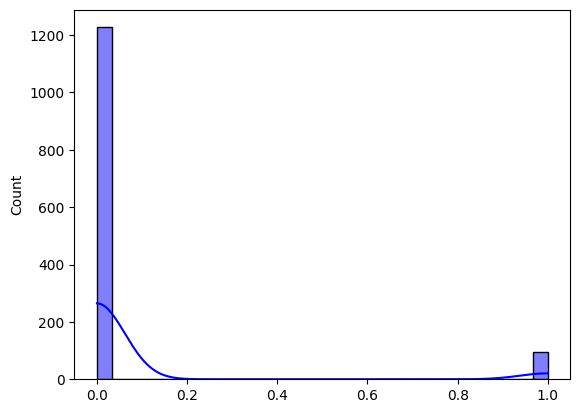

In [119]:
from src.utils.plot_distrubution import plot_distribution

plot_distribution(y, threshold=-6)

## c) Data Splitting into Training, Evaluation and Testing

In [120]:
from sklearn.model_selection import train_test_split

# Convert risk values into binary classes based on the threshold specified in the challenge
y_class = np.where(y >= -6, 1, 0)

# Split the data into training and testing sets (80% training, 20% testing)
# 'stratify' ensures proportional class distribution in train-test split using 'y_class'.
X_train_eval, X_test, y_train_eval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y_class
)

print("Training and Evaluation Set Shapes:")
print(X_train_eval.shape)  # Shape of the features in the training and evaluation set
print(
    y_train_eval.shape
)  # Shape of the target variable in the training and evaluation set
print("\nTesting Set Shapes:")
print(X_test.shape)  # Shape of the features in the testing set
print(y_test.shape)  # Shape of the target variable in the testing set

Training and Evaluation Set Shapes:
(1058, 16)
(1058,)

Testing Set Shapes:
(265, 16)
(265,)


In [121]:
# Convert risk values into binary classes based on the threshold specified in the challenge
y_class_val = np.where(y_train_eval >= -6, 1, 0)

# Split the remaining 80% into training and evaluation/validation sets (80/20 split) using stratify again
X_train, X_val, y_train, y_val = train_test_split(
    X_train_eval,
    y_train_eval,
    test_size=0.20,
    random_state=21,
    shuffle=True,
    stratify=y_class_val,
)

print("Training Set Shapes:")
print(X_train.shape)  # Shape of the features in the training set
print(y_train.shape)  # Shape of the target variable in the training set
print("\nValidation Set Shapes:")
print(X_val.shape)  # Shape of the features in the validation set
print(y_val.shape)  # Shape of the target variable in the validation set

Training Set Shapes:
(846, 16)
(846,)

Validation Set Shapes:
(212, 16)
(212,)


### High/low risk distribution of training set

Shape of y_train_class: (846,)
Risk Distribution Statistics:
High Risk: 62
Low Risk: 784
Percent High Risk: 7.328605200945627


{'High Risk': 62, 'Low Risk': 784, 'Percent High Risk': 7.328605200945627}

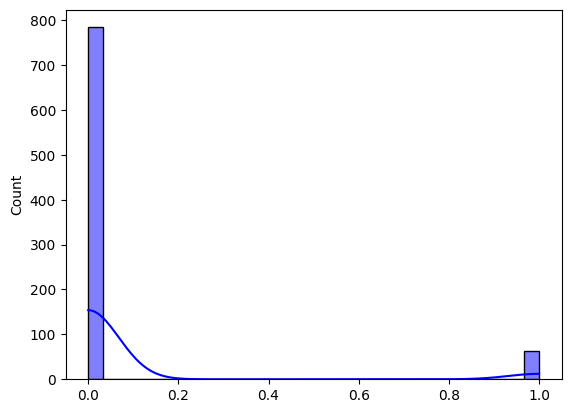

In [122]:
# Convert risk values into binary classes for the training set
y_train_class = np.where(y_train >= -6, 1, 0)

# Print the shape of the binary classes array
print("Shape of y_train_class:", y_train_class.shape)

# Display the distribution of the binary classes
plot_distribution(y_train_class, threshold=0.5)

### High/low risk distribution of validation set

Shape of y_eval_class: (212,)
Risk Distribution Statistics:
High Risk: 15
Low Risk: 197
Percent High Risk: 7.0754716981132075


{'High Risk': 15, 'Low Risk': 197, 'Percent High Risk': 7.0754716981132075}

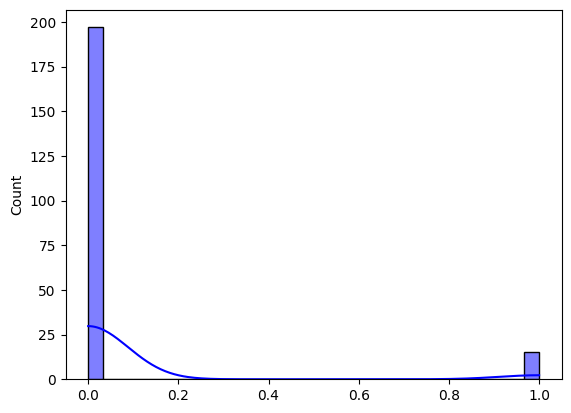

In [123]:
# Convert risk values into binary classes for the validation set
y_eval_class = np.where(y_val >= -6, 1, 0)

# Print the shape of the binary classes array
print("Shape of y_eval_class:", y_eval_class.shape)

# Display the distribution of the binary classes
plot_distribution(y_eval_class, threshold=0.5)

### High/low risk distribution of testing set

Shape of y_test_class: (265,)
Risk Distribution Statistics:
High Risk: 19
Low Risk: 246
Percent High Risk: 7.169811320754717


{'High Risk': 19, 'Low Risk': 246, 'Percent High Risk': 7.169811320754717}

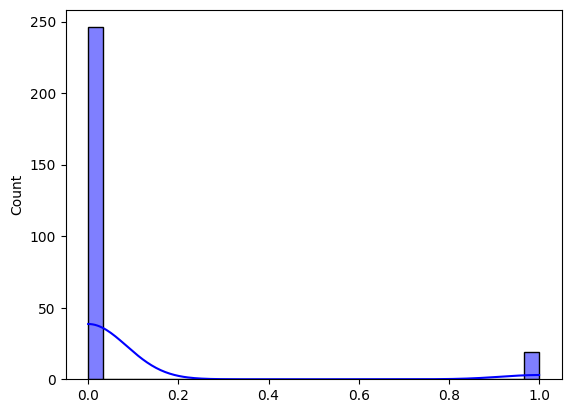

In [124]:
# Convert risk values into binary classes for the testing set
y_test_class = np.where(y_test >= -6, 1, 0)

# Print the shape of the binary classes array
print("Shape of y_test_class:", y_test_class.shape)

# Display the distribution of the binary classes
plot_distribution(y_test_class, threshold=0.5)

## d) Over Sampling with SMOTE (Synthetic Minority Over-sampling Technique)

[SMOTE](https://www.jair.org/index.php/jair/article/view/11192) is a technique used to address class imbalance in machine learning datasets, particularly in classification tasks. It works by generating synthetic samples for the minority class, thereby balancing the class distribution. SMOTE selects minority class instances and generates synthetic samples by interpolating between these instances and their nearest neighbors. This helps in mitigating the problem of class imbalance and improving the performance of machine learning models, especially those sensitive to class distribution.

In [125]:
from imblearn.over_sampling import SMOTE

# Initialize the SMOTE object with specified parameters
smote = SMOTE(
    random_state=42, k_neighbors=30
)  # Number of nearest neighbors to use for generating synthetic samples

# Resample the training data using SMOTE using unscaled training features and binary representation of trained targets
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_class)

# Print the shapes of the resampled training data
print("Resampled Training Set Shapes:")
print(X_train_resampled.shape)  # Shape of the resampled features in the training set
print(
    y_train_resampled.shape
)  # Shape of the resampled target variable in the training set

Resampled Training Set Shapes:
(1568, 16)
(1568,)


### High/low risk distribution of resampled training set

Risk Distribution Statistics:
High Risk: 784
Low Risk: 784
Percent High Risk: 50.0


{'High Risk': 784, 'Low Risk': 784, 'Percent High Risk': 50.0}

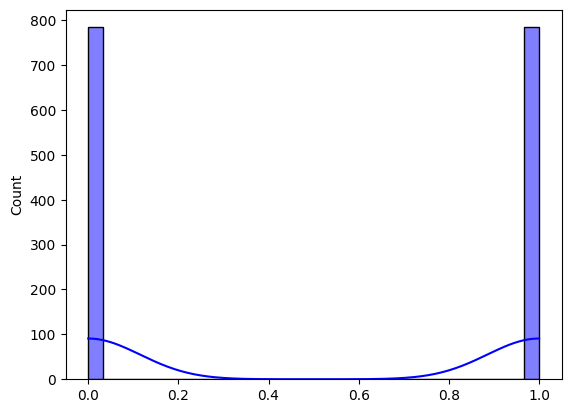

In [126]:
# Display the distribution of the resampled binary classes
plot_distribution(y_train_resampled, threshold=0.5)

## e) Scaling

In [127]:
print("Resampled Training Set Shape:", y_train_resampled.shape)
print("Evaluation Set Shape:", y_train_eval.shape)
print("Validation Set Shape:", y_val.shape)
print("Testing Set Shape:", y_test.shape)

Resampled Training Set Shape: (1568,)
Evaluation Set Shape: (1058,)
Validation Set Shape: (212,)
Testing Set Shape: (265,)


In [128]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
# MinMaxScaler is used to scale the features to a range between 0 and 1 (uniformity across features)
feature_scaler = MinMaxScaler()

# Reshape X to ensure it's a 2D array for the scaler's fit_transform method
X_train_rescaled = feature_scaler.fit_transform(X_train_resampled)
X_train_eval_rescaled = feature_scaler.transform(X_train_eval)
X_eval_rescaled = feature_scaler.transform(X_val)
X_test_rescaled = feature_scaler.transform(X_test)

print("Shape of X_train_rescaled:", X_train_rescaled.shape)
print("Shape of X_train_eval_rescaled:", X_train_eval_rescaled.shape)
print("Shape of X_eval_rescaled:", X_eval_rescaled.shape)
print("Shape of X_test_rescaled:", X_test_rescaled.shape)

Shape of X_train_rescaled: (1568, 16)
Shape of X_train_eval_rescaled: (1058, 16)
Shape of X_eval_rescaled: (212, 16)
Shape of X_test_rescaled: (265, 16)


# 2) Modeling

This model is a feedforward neural network with an input layer, one hidden layer, and an output layer. The architecture includes:

- **Input Layer**: 64 neurons with ReLU activation.
- **Hidden Layer**: 32 neurons with ReLU activation.
- **Output Layer**: 1 neuron with linear activation for regression.

The model is compiled using the Adam optimizer (learning rate = 0.001) and mean squared error loss.

## a) Build Neural Network Model

Here you can input your models and comment out the others

### v1.0.0

In [129]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers.legacy import Adam
#
# # Define the neural network model: linear stack of layers
# model = Sequential()
#
# # Add input layer and hidden layers
# model.add(Dense(64, input_dim=X_train_rescaled.shape[1],
#                 activation='relu'))  # Input layer with 64 neurons and ReLU activation
# model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons and ReLU activation
#
# # Add output layer
# # sigmoid for binary classification
# model.add(Dense(1, activation='sigmoid'))  # Output layer with linear activation for regression task
#
# # Compile the model
# # binary_crossentropy: Used for binary classification problems, computes loss based on probability distributions of binary classes.
# model.compile(optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate of 0.001
#               loss='binary_crossentropy', metrics=['accuracy'])  # Mean squared error loss for regression
#
# # Print model summary
# model.summary()  # Display the architecture and parameters of the neural network model

### v2.0.0

In [130]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam, SGD

# Define the neural network model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(124, input_dim=X_train_rescaled.shape[1], activation="relu"))
model.add(BatchNormalization())  # Batch normalization layer
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add output layer
# sigmoid for binary classification
model.add(Dense(1, activation="sigmoid"))  # Linear activation for regression task

# Compile the model
# binary_crossentropy: Used for binary classification problems, computes loss based on probability distributions of binary classes.
# model.compile(
#     optimizer=SGD(
#         learning_rate=0.01, momentum=0.9
#     ),  # Adam optimizer with learning rate of 0.001
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )  # Mean squared error loss for regression
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate of 0.001
    loss="binary_crossentropy",
    metrics=["accuracy"],
)  # Mean squared error loss for regression

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 124)               2108      
                                                                 
 batch_normalization_10 (Ba  (None, 124)               496       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 124)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8000      
                                                                 
 batch_normalization_11 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 64)               

### v3.0.0

## b) Train the model

**fit():**
- During training, the model is repeatedly exposed to batches of training data (X_train_rescaled and y_train_resampled). For each batch, the model computes predictions, calculates the loss (difference between predicted and actual values), and updates the model's parameters (weights and biases) using an optimization algorithm (e.g., Adam optimizer) to minimize the loss.

- The validation data (X_eval_rescaled and y_eval_class) are used periodically (after each epoch) to evaluate the model's performance on unseen data. This helps monitor the model's generalization ability and detect overfitting.

In [131]:
# X_train_rescaled: Scaled features of the training set
# y_train_resampled: Binary classes (after oversampling) corresponding to the training set
# validation_data=(X_eval_rescaled, y_eval_class): Data used for validation during training
class_weights = {0: 1, 1: 200}

history = model.fit(
    X_train_rescaled,
    y_train_resampled,
    shuffle=True,
    epochs=30,
    batch_size=64,
    validation_data=(X_eval_rescaled, y_eval_class),
    # class_weight=class_weights,
)

Epoch 1/30
25/25 [==============================] - 2s 49ms/step - loss: 0.7297 - accuracy: 0.6403 - val_loss: 0.7370 - val_accuracy: 0.4009
Epoch 2/30
25/25 [==============================] - 0s 18ms/step - loss: 0.5092 - accuracy: 0.7672 - val_loss: 0.7713 - val_accuracy: 0.3066
Epoch 3/30
25/25 [==============================] - 0s 20ms/step - loss: 0.4065 - accuracy: 0.8087 - val_loss: 0.7525 - val_accuracy: 0.3726
Epoch 4/30
25/25 [==============================] - 0s 18ms/step - loss: 0.3628 - accuracy: 0.8489 - val_loss: 0.7148 - val_accuracy: 0.4811
Epoch 5/30
25/25 [==============================] - 0s 17ms/step - loss: 0.3214 - accuracy: 0.8814 - val_loss: 0.6681 - val_accuracy: 0.5849
Epoch 6/30
25/25 [==============================] - 0s 18ms/step - loss: 0.3000 - accuracy: 0.8890 - val_loss: 0.5925 - val_accuracy: 0.7264
Epoch 7/30
25/25 [==============================] - 0s 17ms/step - loss: 0.2947 - accuracy: 0.8820 - val_loss: 0.5283 - val_accuracy: 0.8113
Epoch 8/30
25

### Plot the accuracy of the model for the Training and Validation data

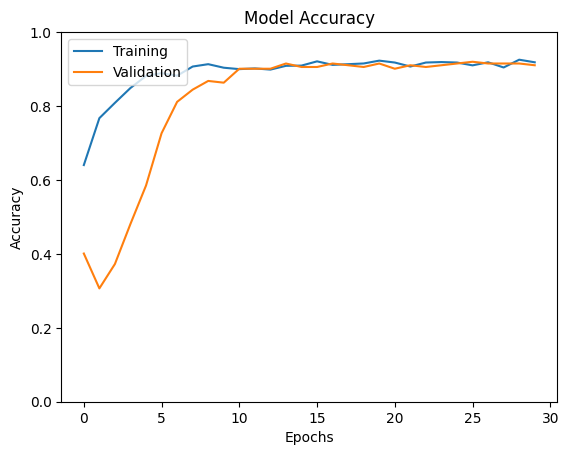

In [132]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Training", "Validation"], loc="upper left")

# Set y-axis limits from 0 to 1
plt.ylim(0, 1)

# Show figure
plt.show()

### Plot the loss of the model for the Training and Validation data

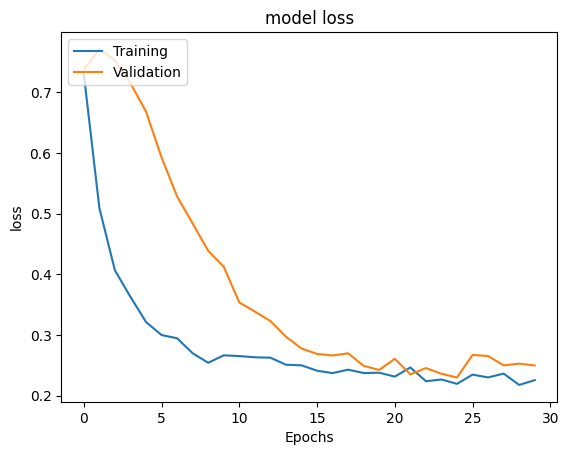

In [133]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(["Training", "Validation"], loc="upper left")

# Show figure
plt.show()

## c) Predicting the model

In [134]:
# Predict using the trained model on rescaled testing data
risk_predictions = model.predict(X_test_rescaled)

9/9 [==============================] - 0s 8ms/step


### High/low risk distribution of predicted risk without classification

<Axes: ylabel='Count'>

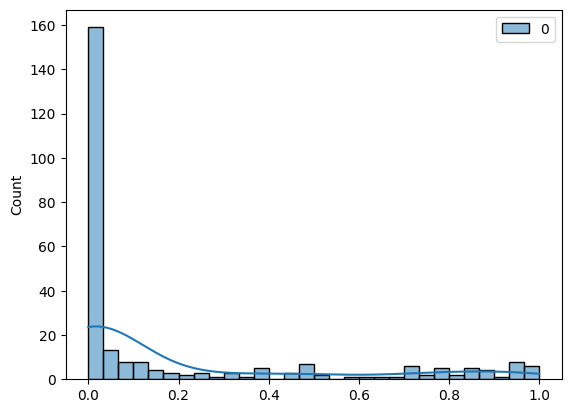

In [135]:
# Display the distribution of the predicted risk
plot_distribution(risk_predictions, classification=False)

### Find best threshold for binary classification for F-beta score

In [136]:
from sklearn.metrics import fbeta_score

# Initialize variables to store the best threshold and its corresponding F-beta score
best_threshold = None
best_score = -1

# Iterate over a range of thresholds
for threshold in np.linspace(0, 1, 1000):
    # Convert risk predictions to binary predictions based on the current threshold
    y_pred = np.where(risk_predictions >= threshold, 1, 0)

    # Calculate the F-beta score for the current threshold
    score = fbeta_score(y_test_class, y_pred, beta=2)

    # Update the best threshold and score if the current score is better
    if score > best_score:
        best_score = score
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best F-beta Score:", best_score)

Best Threshold: 0.4624624624624625
Best F-beta Score: 0.7421874999999999


### High/low risk distribution of risk predictions with computed threshold

Risk Distribution Statistics:
High Risk: 52
Low Risk: 213
Percent High Risk: 19.62264150943396


{'High Risk': 52, 'Low Risk': 213, 'Percent High Risk': 19.62264150943396}

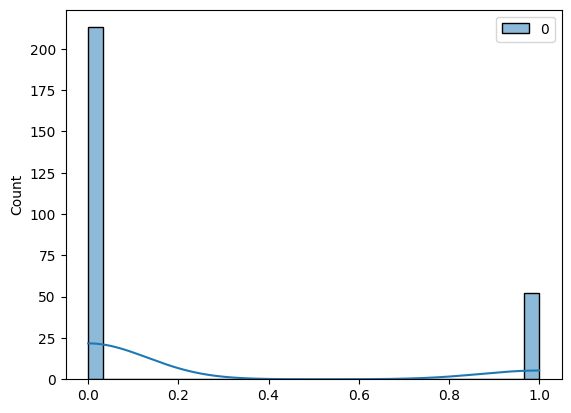

In [137]:
# Display the distribution of the resampled binary classes
plot_distribution(risk_predictions, threshold=best_threshold)

# 3) Evaluation of the model

**F-beta score**:

It's a metric that balances precision and recall, with the emphasis on recall. By using the beta parameter (here, set to 2), we're placing more importance on recall than precision. This is crucial in scenarios where false negatives (missed positive cases) are more costly than false positives.

**MSE_HR score**:

It's a modified mean squared error (MSE) metric that's adapted to handle high-risk scenarios. It penalizes predictions that fall below a certain threshold (here, -6) more severely, as these are considered high-risk predictions.


**Explanation for the values [-5, -6.0001]:**

Took from the [Case Study](https://github.com/jaimeperezsanchez/Collision_Avoidance_Challenge_Deep_Learning/blob/master/Technical_Report.pdf):
For the MSE computation, we set all the low-risk prediction as close as possible to the threshold (risk greater or equal to -6). This makes the scores improve a lot as the maximum difference while computing the MSE between two values is now -6 (the high-risk range) instead of -30 (the total risk range).

In [138]:
from src.utils.calculate_statistics import calculate_statistics_for_evaluation

predictions_real = np.where(risk_predictions >= best_threshold, -5, -6.0001)

# Calculate F-beta and MSE_HR scores
f_beta = calculate_statistics_for_evaluation(y_pred=predictions_real, y_true=y_test)

F-beta Score: 0.7421874999999999


## END